# Support Vector Machine

In [1]:
# file path exist
import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string


# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.svm import LinearSVC

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [2]:
# For non English data
filename  = 'Eng-Hin-data/hindi-anot-shuffled'

df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)
data = df

### Class count

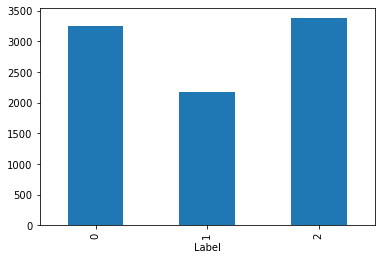

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [4]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

### Data Preprocessing

In [5]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [6]:
#Removing punctuations
data['Text'] = data['Text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [7]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [8]:
data.shape

(8793, 2)

In [9]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [11]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in tokens]

In [12]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [13]:
# Removing Stopwords
stoplist=open("Devanagari/stopwords.txt","r")

In [14]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [15]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [16]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.tail(9)

,Text_Final,tokens,Label,0,1,2,Category_id
8784,sardanarohit हमारे पास भी परमाणु बम है वो क्या...,"[sardanarohit, हमारे, पास, भी, परमाणु, बम, है,...",0,1,0,0,0
8785,AIMPLBOfficial इन सभी जेहादी सूअरों का एक ही इ...,"[AIMPLBOfficial, इन, सभी, जेहादी, सूअरों, का, ...",2,0,0,1,2
8786,007AliSohrab ProfNoorul नूरूल भाई। क्या बिस्मि...,"[007AliSohrab, ProfNoorul, नूरूल, भाई।, क्या, ...",1,0,1,0,1
8787,ajitanjum तुझे भी बैंगलोर जलने का ना अफसोस है ...,"[ajitanjum, तुझे, भी, बैंगलोर, जलने, का, ना, अ...",2,0,0,1,2
8788,atullondhe राहुल गांधी जिंदाबाद,"[atullondhe, राहुल, गांधी, जिंदाबाद]",0,1,0,0,0
8789,पैगंबर हज़रत मुहम्मद सल्लल्लाहु अलैहि वसल्लम क...,"[पैगंबर, हज़रत, मुहम्मद, सल्लल्लाहु, अलैहि, वस...",1,0,1,0,1
8790,कर्नाटक बेंगलुरू में अल्लाह मोहम्मद गांडू के ज...,"[कर्नाटक, बेंगलुरू, में, अल्लाह, मोहम्मद, गांड...",2,0,0,1,2
8791,अच्छी खबर है ऐसे एक एक कर सभी जेहादी भारतीय फ़...,"[अच्छी, खबर, है, ऐसे, एक, एक, कर, सभी, जेहादी,...",2,0,0,1,2
8792,RuzenaMalik जनता चाइना से दीवाली की लड़ी खरीदे...,"[RuzenaMalik, जनता, चाइना, से, दीवाली, की, लड़...",0,1,0,0,0


In [17]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# Support Vector Method (SVM) and Random Forest Method (RFM)

We referred a blog on Multi class classification for SVM and RFM [2]

### Generating features using TF-IDF Vectorizer method

In [18]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(8793, 16880)

### Testing SVM models using K-fold cross validation


In [19]:
import random

# Creating model 
model = LinearSVC()

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model, features, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Support Vector with Tf-idf: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )


Support Vector with Tf-idf: 
1 0.8556818181818182
2 0.8863636363636364
3 0.8738636363636364
4 0.8782707622298066
5 0.8452787258248009
6 0.8543799772468714
7 0.8725824800910125
8 0.8748577929465301
9 0.8612059158134243
10 0.8691695108077361
 Average Accuracy : 0.8671654255869274


In [20]:
### Spliting data 80/ 20

In [21]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10, random_state=42)

### SVM - Generating model 

In [22]:
# generate Linear SVM model
model = LinearSVC()
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### SVM - Showing some prediction

In [23]:
# 0
print(clf.predict(vectorizer.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['2']


In [24]:
# 2
print(clf.predict(vectorizer.transform(["Muslim asshole !"])))

['2']


In [25]:
# 1
print(clf.predict(vectorizer.transform(["Islam is beautiful"])))

['2']


In [26]:
print(clf.predict(vectorizer.transform(["Blacks are asshole"])))

['0']


###  SVM - Displaying false-positive rate (FPR) and true positive rate (TPR)

                          Support Vector Method


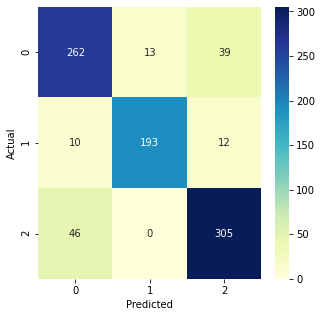

In [27]:
from sklearn.metrics import confusion_matrix
print("                          Support Vector Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix

In [28]:
results = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[262  13  39]
 [ 10 193  12]
 [ 46   0 305]]
Accuracy Score : 0.8636363636363636
Report : 
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       314
           1       0.94      0.90      0.92       215
           2       0.86      0.87      0.86       351

    accuracy                           0.86       880
   macro avg       0.87      0.87      0.87       880
weighted avg       0.86      0.86      0.86       880



# SVM - BOW

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features1 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.Label
features1.shape

(8793, 8908)

In [30]:
# Using similar split 80/20
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features1, labels, data.index, test_size=0.10, random_state=12)

In [31]:
# generate Linear SVM model
model2 = LinearSVC()
clf2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

### SVM - BOW - Showing some prediction

In [32]:
# 0
print(clf2.predict(count_vect.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['2']


In [33]:
# 0
print(clf2.predict(count_vect.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['0']


In [34]:
# 0
print(clf2.predict(count_vect.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['0']


In [35]:
# 2
print(clf2.predict(count_vect.transform(["Muslim asshole !"])))

['2']


In [36]:
# 1
print(clf2.predict(count_vect.transform(["Islam is beautiful religion with good people"])))

['0']


In [37]:
# 1
print(clf2.predict(count_vect.transform(["@dillyaali @OlaitanHabibat @MubarakDalhat11 @FakhuusHashim you are not Muslim so don't insult Quran verses I warned you"])))

['2']


In [38]:
# 0
print(clf2.predict(count_vect.transform(["Blacks are asshole"])))

['2']


###  SVM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     Support Vector Method - BOW


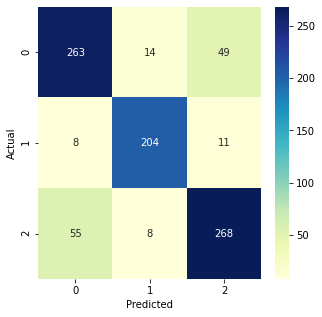

In [39]:
from sklearn.metrics import confusion_matrix
print("                     Support Vector Method - BOW")
conf_mat = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [40]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[263  14  49]
 [  8 204  11]
 [ 55   8 268]]
Accuracy Score : 0.8352272727272727
Report : 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       326
           1       0.90      0.91      0.91       223
           2       0.82      0.81      0.81       331

    accuracy                           0.84       880
   macro avg       0.84      0.84      0.84       880
weighted avg       0.83      0.84      0.84       880



### SVM with BOW kfold

In [41]:
# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model2, features1, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )

Random Forest with BOW: 
1 0.8227272727272728
2 0.8670454545454546
3 0.8511363636363637
4 0.8555176336746303
5 0.8168373151308305
6 0.8373151308304891
7 0.8464163822525598
8 0.8486916951080774
9 0.838452787258248
10 0.8498293515358362
 Average Accuracy : 0.8433969386699763


### Reference

[2] Multi-Class Text Classification with Scikit-Learn by Susan Li

[3] Scikit-Learn Documentation https://scikit-learn.org/